In [93]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter

In [94]:
df = pd.read_csv('/Users/paolocadei/Desktop/GeolocationGuesserAI/gemini_output.csv', delimiter=',', error_bad_lines=False, warn_bad_lines=True)
df['Analysis Result'] = df['Analysis Result'].str.extract(r'\[(.*)\]')

/var/folders/n9/6pwt6r5x7cl54yr_vrdyfr_w0000gn/T/ipykernel_40591/1828366261.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('/Users/paolocadei/Desktop/GeolocationGuesserAI/gemini_output.csv', delimiter=',', error_bad_lines=False, warn_bad_lines=True)
/var/folders/n9/6pwt6r5x7cl54yr_vrdyfr_w0000gn/T/ipykernel_40591/1828366261.py:1: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('/Users/paolocadei/Desktop/GeolocationGuesserAI/gemini_output.csv', delimiter=',', error_bad_lines=False, warn_bad_lines=True)
Skipping line 22559: expected 2 fields, saw 9



In [95]:
df.head()

,Image Name,Analysis Result
0,roi_0_0.jpeg,"""Sky"", ""Road"", ""Soil"", ""Tree"", ""Vegetation"", ""..."
1,roi_10006_0.jpeg,"""House"", ""Building"", ""Car"", ""Vehicle"", ""Road"",..."
2,roi_10009_0.jpeg,"""Vegetation"", ""Wall"", ""Soil"", ""Bush"""
3,roi_10009_1.jpeg,"""Sky"""
4,roi_10009_2.jpeg,"""Sky"""


In [96]:
# Convert all values in the column to strings, then split
df['Analysis Result'] = df['Analysis Result'].apply(
    lambda x: str(x).split(',') if isinstance(x, str) else []
)

# Display the updated DataFrame
print(df.head())


         Image Name                                    Analysis Result
0      roi_0_0.jpeg  ["Sky",  "Road",  "Soil",  "Tree",  "Vegetatio...
1  roi_10006_0.jpeg  ["House",  "Building",  "Car",  "Vehicle",  "R...
2  roi_10009_0.jpeg          ["Vegetation",  "Wall",  "Soil",  "Bush"]
3  roi_10009_1.jpeg                                            ["Sky"]
4  roi_10009_2.jpeg                                            ["Sky"]


In [97]:
# Extract the first number after "roi_" in the "Image Name" column
df['image_name'] = df['Image Name'].str.extract(r'roi_(\d+)_')

# Remove rows where 'First Number' is NaN
df = df.dropna(subset=['image_name'])

# Optionally, convert the column to integer after removing NaN rows
df['image_name'] = df['image_name'].astype(str)

# Add .png to the 'image_name' column
df['image_name'] = df['image_name'].apply(lambda x: f"{x}.png")

# Display the updated DataFrame
print(df.head())


         Image Name                                    Analysis Result  \
0      roi_0_0.jpeg  ["Sky",  "Road",  "Soil",  "Tree",  "Vegetatio...   
1  roi_10006_0.jpeg  ["House",  "Building",  "Car",  "Vehicle",  "R...   
2  roi_10009_0.jpeg          ["Vegetation",  "Wall",  "Soil",  "Bush"]   
3  roi_10009_1.jpeg                                            ["Sky"]   
4  roi_10009_2.jpeg                                            ["Sky"]   

  image_name  
0      0.png  
1  10006.png  
2  10009.png  
3  10009.png  
4  10009.png  


In [98]:
# Group by 'First Number' and combine lists in 'Analysis Result'
df_combined = df.groupby('image_name', as_index=False).agg({
    'Analysis Result': 'sum'  # Combine lists by summing them
})

# Display the resulting DataFrame
print(df_combined.head())


  image_name                                    Analysis Result
0      0.png  ["Sky",  "Road",  "Soil",  "Tree",  "Vegetatio...
1      1.png  ["Sky",  "Tree",  "Vegetation",  "Bush", "Sky"...
2  10006.png  ["House",  "Building",  "Car",  "Vehicle",  "R...
3  10009.png  ["Vegetation",  "Wall",  "Soil",  "Bush", "Sky...
4  10011.png  ["Sky",  "Tree",  "Vegetation",  "Building",  ...


In [99]:
# Flatten all lists in the "Analysis Result" column into a single list
# and standardize to lowercase
all_values = [
    item.strip().lower() for sublist in df_combined['Analysis Result'] if isinstance(sublist, list) for item in sublist
]

# Count the occurrences of each value
value_counts = Counter(all_values)

# Convert the counts to a DataFrame for better visualization
counts_df = pd.DataFrame(value_counts.items(), columns=['Object', 'Count']).sort_values(by='Count', ascending=False)

# Display the counts
print(counts_df)

                Object  Count
4         "vegetation"  15485
0                "sky"   7799
2               "soil"   7154
17           "nothing"   6807
7               "bush"   6720
..                 ...    ...
74   "air conditioner"      2
119        "mailboxes"      2
118     "traffic cone"      2
117             "ship"      2
173         "contrail"      2

[174 rows x 2 columns]


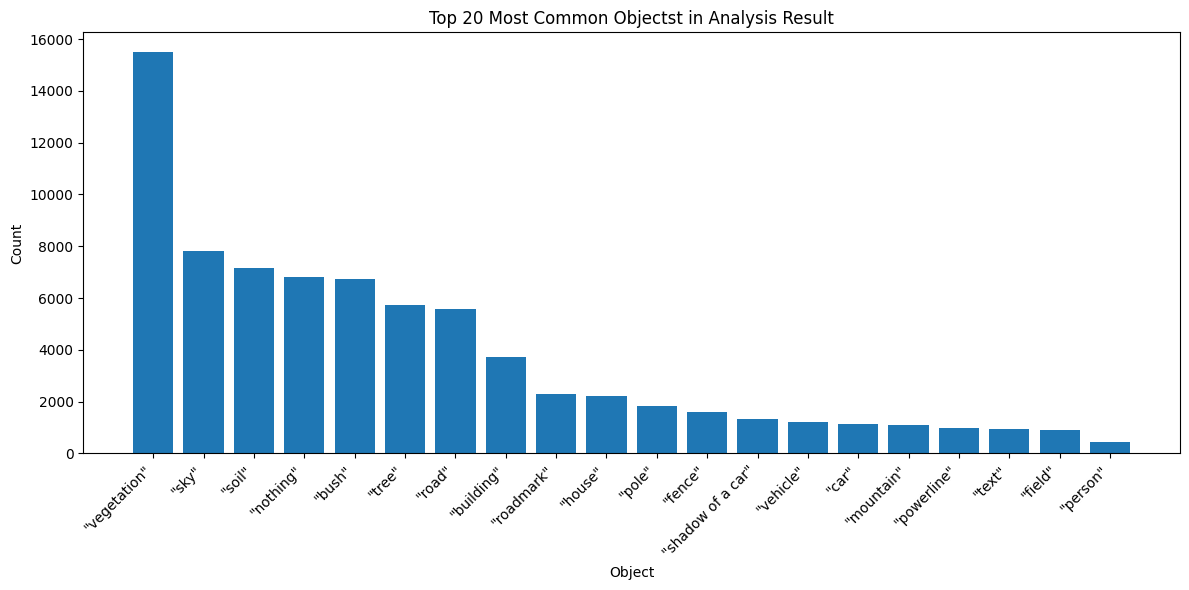

In [100]:
# Plot the top 20 most common values
top_n = 20
top_counts = counts_df.head(top_n)

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(top_counts['Object'], top_counts['Count'])
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.xlabel('Object')
plt.ylabel('Count')
plt.title('Top 20 Most Common Objectst in Analysis Result')
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [101]:
test_predictions_path = '/Users/paolocadei/Desktop/GeolocationGuesserAI/models/ResNet50/test_predictions.csv'
df_test_predictions = pd.read_csv(test_predictions_path)

# Merge the two datasets on the 'image_name' column
merged_df = pd.merge(df_combined, df_test_predictions[['image_name', 'sub-region', 'model_prediction']], on='image_name', how='left')

# Display the merged DataFrame
print(merged_df.head())

  image_name                                    Analysis Result  \
0      0.png  ["Sky",  "Road",  "Soil",  "Tree",  "Vegetatio...   
1      1.png  ["Sky",  "Tree",  "Vegetation",  "Bush", "Sky"...   
2  10006.png  ["House",  "Building",  "Car",  "Vehicle",  "R...   
3  10009.png  ["Vegetation",  "Wall",  "Soil",  "Bush", "Sky...   
4  10011.png  ["Sky",  "Tree",  "Vegetation",  "Building",  ...   

        sub-region  model_prediction  
0              NaN               NaN  
1              NaN               NaN  
2  Southern Europe  Northern America  
3  Southern Europe   Southern Europe  
4  Southern Europe  Northern America  


In [102]:
# Create a new column 'is_correct' to indicate if the prediction matches the sub-region
merged_df['is_correct'] = merged_df['model_prediction'] == merged_df['sub-region']

# Display the updated DataFrame
print(merged_df.head())


  image_name                                    Analysis Result  \
0      0.png  ["Sky",  "Road",  "Soil",  "Tree",  "Vegetatio...   
1      1.png  ["Sky",  "Tree",  "Vegetation",  "Bush", "Sky"...   
2  10006.png  ["House",  "Building",  "Car",  "Vehicle",  "R...   
3  10009.png  ["Vegetation",  "Wall",  "Soil",  "Bush", "Sky...   
4  10011.png  ["Sky",  "Tree",  "Vegetation",  "Building",  ...   

        sub-region  model_prediction  is_correct  
0              NaN               NaN       False  
1              NaN               NaN       False  
2  Southern Europe  Northern America       False  
3  Southern Europe   Southern Europe        True  
4  Southern Europe  Northern America       False  


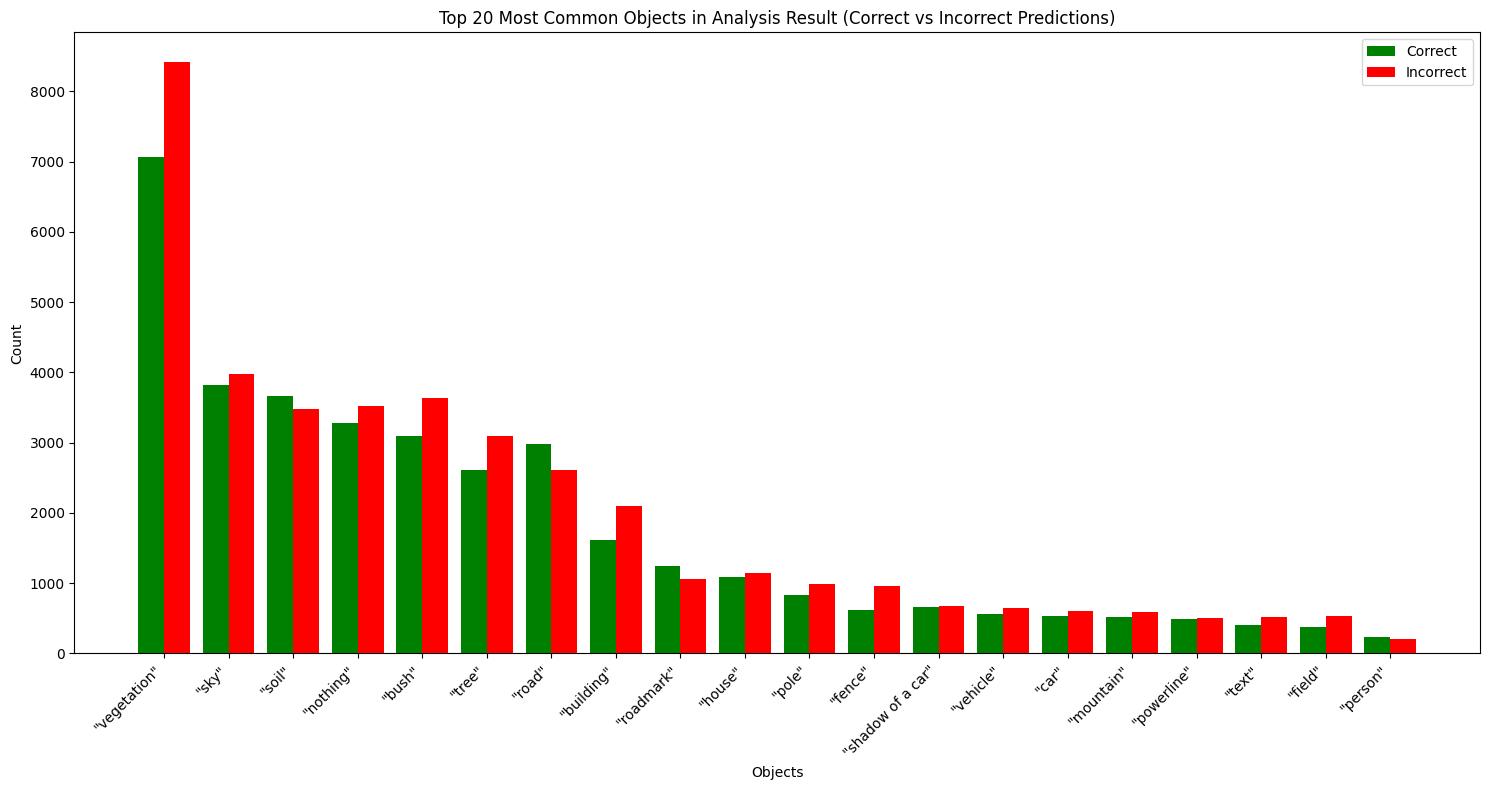

In [103]:
# Flatten all lists in the "Analysis Result" column into a single list, standardizing to lowercase
all_values_correct = [
    item.strip().lower()
    for sublist in merged_df[merged_df['is_correct']]['Analysis Result']
    if isinstance(sublist, list)
    for item in sublist
]
all_values_incorrect = [
    item.strip().lower()
    for sublist in merged_df[~merged_df['is_correct']]['Analysis Result']
    if isinstance(sublist, list)
    for item in sublist
]

# Count the occurrences of each value
correct_counts = Counter(all_values_correct)
incorrect_counts = Counter(all_values_incorrect)

# Combine counts into a DataFrame for visualization
objects = list(set(correct_counts.keys()).union(set(incorrect_counts.keys())))
data = {
    'Object': objects,
    'Correct': [correct_counts.get(obj, 0) for obj in objects],
    'Incorrect': [incorrect_counts.get(obj, 0) for obj in objects],
}
plot_df = pd.DataFrame(data)

# Sort by total count and keep the top 20 objects
plot_df['Total'] = plot_df['Correct'] + plot_df['Incorrect']
plot_df = plot_df.sort_values(by='Total', ascending=False).head(20)

# Plot a side-by-side bar chart
plt.figure(figsize=(15, 8))
bar_width = 0.4
x = range(len(plot_df))

# Plot bars for correct and incorrect counts side by side
plt.bar([p - bar_width / 2 for p in x], plot_df['Correct'], width=bar_width, label='Correct', color='green')
plt.bar([p + bar_width / 2 for p in x], plot_df['Incorrect'], width=bar_width, label='Incorrect', color='red')

# Add labels and legend
plt.xlabel('Objects')
plt.ylabel('Count')
plt.title('Top 20 Most Common Objects in Analysis Result (Correct vs Incorrect Predictions)')
plt.xticks(x, plot_df['Object'], rotation=45, ha='right')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [104]:
# Explode the "Analysis Result" column to create one row per object
df_exploded = merged_df.explode('Analysis Result')

# Convert objects to lowercase for consistency
df_exploded['Analysis Result'] = df_exploded['Analysis Result'].str.strip().str.lower()

# Group by each unique object in the "Analysis Result" column and calculate statistics
object_stats = df_exploded.groupby('Analysis Result')['is_correct'].agg(
    total_occurrences='count',
    correct_predictions='sum',
    incorrect_predictions=lambda x: x.count() - x.sum()
).reset_index()

# Calculate the accuracy percentage for each object
object_stats['accuracy'] = (object_stats['correct_predictions'] / object_stats['total_occurrences']) * 100

# Sort by accuracy or total occurrences for analysis
object_stats = object_stats.sort_values(by='accuracy', ascending=False)

# Display the statistics
object_stats


,Analysis Result,total_occurrences,correct_predictions,incorrect_predictions,accuracy
0,,2,2,0,100.0
115,"""ship""",2,2,0,100.0
45,"""drain""",2,2,0,100.0
49,"""fire hydrant""",2,2,0,100.0
54,"""food""",2,2,0,100.0
...,...,...,...,...,...
1,"""ac unit""",2,0,2,0.0
19,"""boxes""",2,0,2,0.0
85,"""pigeon""",2,0,2,0.0
79,"""mineral""",2,0,2,0.0


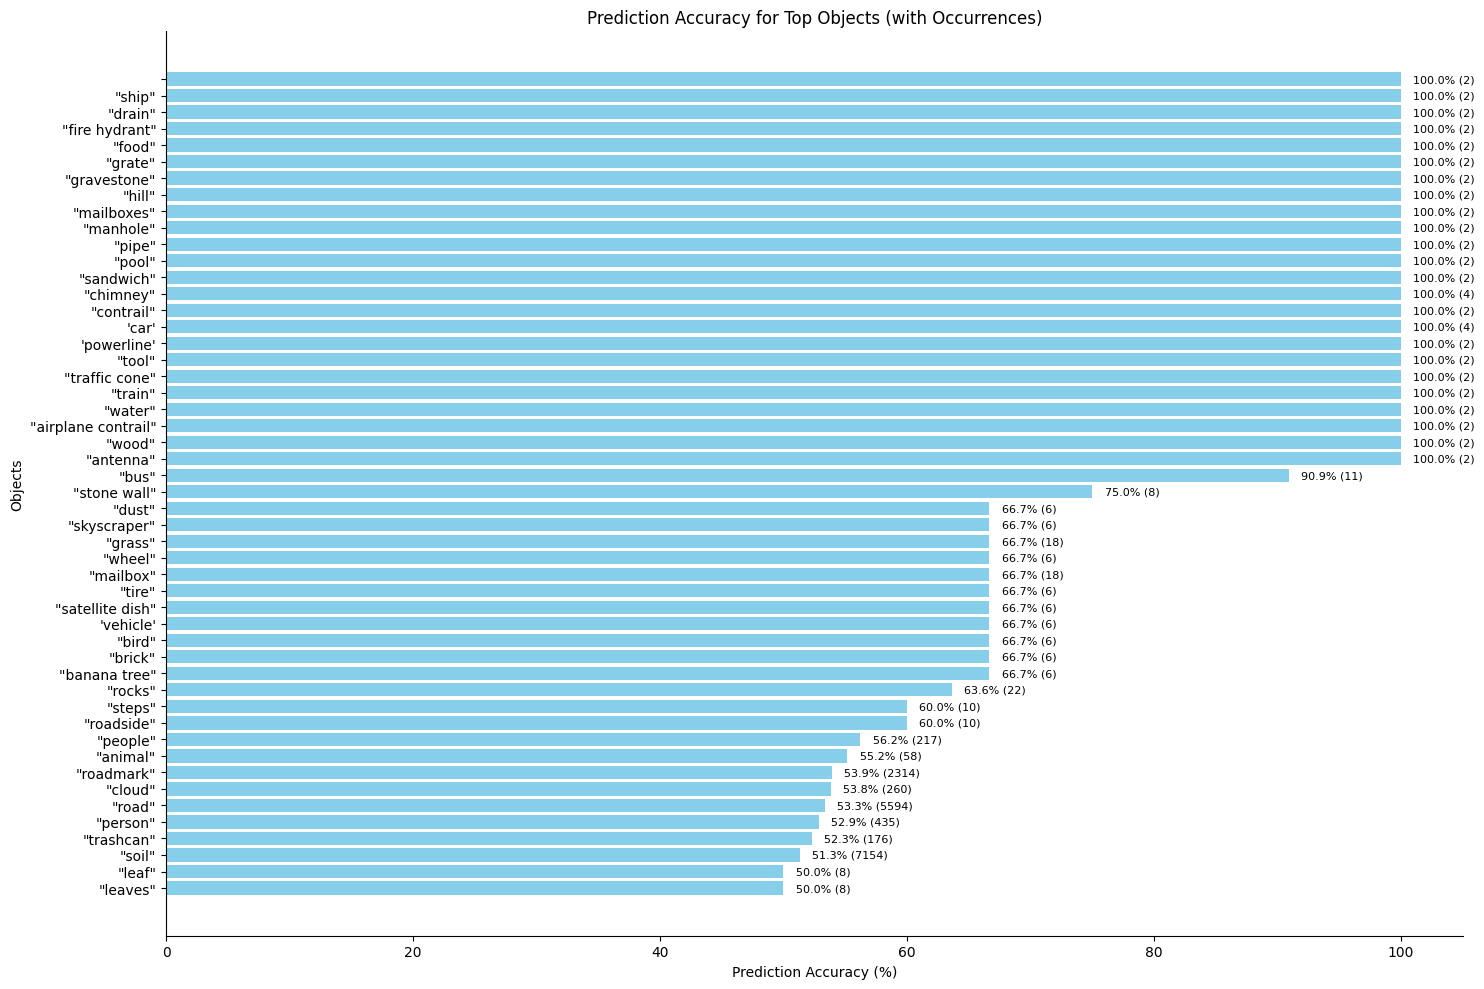

In [ ]:
# Increase the number of objects displayed
top_objects = object_stats.head(50)

# Create a horizontal bar chart
plt.figure(figsize=(15, 10))  # Larger figure size to fit more values
bars = plt.barh(top_objects['Analysis Result'], top_objects['accuracy'], color='skyblue')

# Add text for accuracy and occurrences next to each bar
for bar, total, accuracy in zip(bars, top_objects['total_occurrences'], top_objects['accuracy']):
    plt.text(
        bar.get_width() + 1,  # Position to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Vertically centered
        f'{accuracy:.1f}% ({total})',  # Display accuracy and occurrences
        ha='left', va='center', fontsize=8  # Reduce font size for clarity
    )

# Customize plot
plt.xlabel('Prediction Accuracy (%)')
plt.ylabel('Objects')
plt.title('Prediction Accuracy for Top Objects (with Occurrences)')
plt.gca().invert_yaxis()  # Invert y-axis for better readability

# Remove the right and top spines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()

# Show the plot
plt.show()


In [128]:
import os
import pandas as pd

# Base directory containing the model folders
base_dir = '/Users/paolocadei/Desktop/GeolocationGuesserAI/models/'

# Initialize an empty list to store DataFrames
all_metrics = []

# Loop through each folder in the base directory
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    
    # Skip models named 'test' and 'test2'
    if folder.lower() in ['test', 'test_2']:
        continue
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Path to metrics.csv
        metrics_file = os.path.join(folder_path, 'metrics.csv')
        
        # Check if metrics.csv exists in the folder
        if os.path.exists(metrics_file):
            # Read the metrics.csv
            metrics_df = pd.read_csv(metrics_file)
            
            # Add a column for the model name
            metrics_df['model'] = folder
            
            # Append to the list of DataFrames
            all_metrics.append(metrics_df)

# Concatenate all DataFrames into a single DataFrame
final_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Display the resulting DataFrame
print(final_metrics_df)

# Optionally save the final DataFrame to a CSV
output_file = os.path.join(base_dir, 'compiled_metrics.csv')
final_metrics_df.to_csv(output_file, index=False)
print(f"Compiled metrics saved to {output_file}")


   train_loss  test_loss  train_accuracy  test_accuracy  \
0    1.523815   1.584116        0.502537       0.475641   
1    1.613995   1.836672        0.455376       0.383973   
2    1.300272   1.585170        0.578795       0.462517   
3    1.819323   1.780130        0.395129       0.401670   
4    1.614664   1.858410        0.455942       0.371446   
5    1.818130   1.723791        0.403365       0.421356   
6    1.542370   1.645774        0.494011       0.451581   
7    1.717885   1.725284        0.418170       0.406244   

                         model  
0                     ResNet50  
1  ResNet18_Augmented_Unfrozen  
2           ResNet50_Augmented  
3          ResNet101_Augmented  
4           ResNet18_Augmented  
5  ResNet50_Augmented_Unfrozen  
6                    ResNet101  
7                     ResNet18  
Compiled metrics saved to /Users/paolocadei/Desktop/GeolocationGuesserAI/models/compiled_metrics.csv


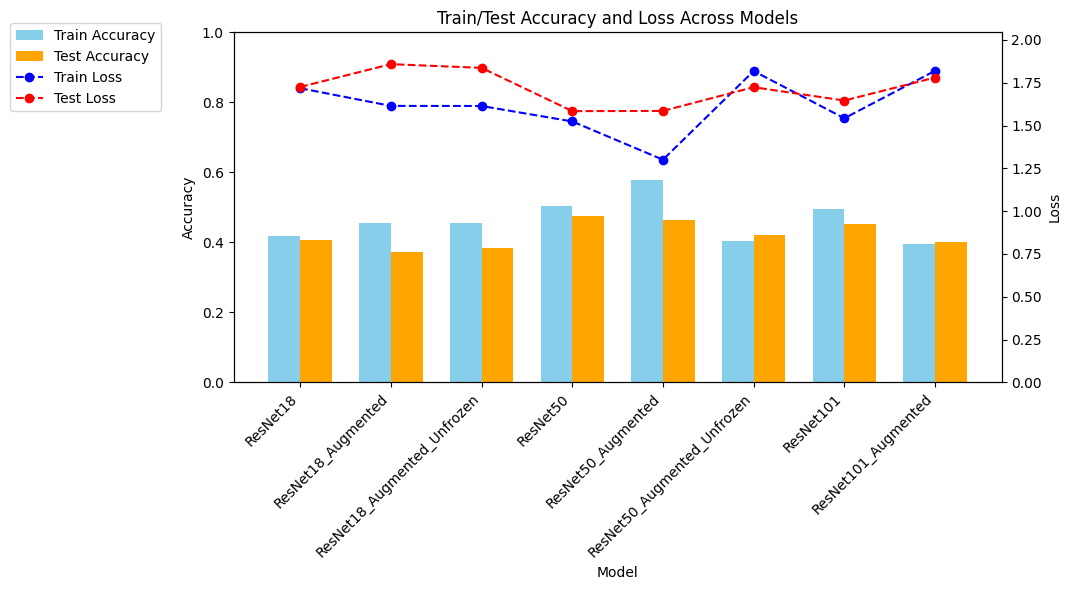

In [146]:
import matplotlib.pyplot as plt
import numpy as np

# Define the desired order of models
desired_order = [
    "ResNet18", 
    "ResNet18_Augmented", 
    "ResNet18_Augmented_Unfrozen", 
    "ResNet50", 
    "ResNet50_Augmented", 
    "ResNet50_Augmented_Unfrozen", 
    "ResNet101", 
    "ResNet101_Augmented"
]

# Set the categorical order and sort the DataFrame
final_metrics_df['model'] = pd.Categorical(final_metrics_df['model'], categories=desired_order, ordered=True)
final_metrics_df = final_metrics_df.sort_values('model')

# Set up the figure and axis
fig, ax1 = plt.subplots(figsize=(15, 6))

# Define bar positions and width
x = np.arange(len(final_metrics_df['model']))
width = 0.35

# Plot bar chart for accuracy
bar1 = ax1.bar(x - width / 2, final_metrics_df['train_accuracy'], width, label='Train Accuracy', color='skyblue')
bar2 = ax1.bar(x + width / 2, final_metrics_df['test_accuracy'], width, label='Test Accuracy', color='orange')

# Customize the primary y-axis (accuracy)
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)  # Assuming accuracy is between 0 and 1
ax1.set_xticks(x)
ax1.set_xticklabels(final_metrics_df['model'], rotation=45, ha='right')
ax1.set_xlabel('Model')

# Create a secondary y-axis for loss
ax2 = ax1.twinx()
line1, = ax2.plot(x, final_metrics_df['train_loss'], label='Train Loss', marker='o', color='blue', linestyle='--')
line2, = ax2.plot(x, final_metrics_df['test_loss'], label='Test Loss', marker='o', color='red', linestyle='--')

# Customize the secondary y-axis (loss)
ax2.set_ylabel('Loss')
ax2.set_ylim(0, max(final_metrics_df[['train_loss', 'test_loss']].max()) * 1.1)

# Add a title
plt.title('Train/Test Accuracy and Loss Across Models')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(
    lines + lines2, 
    labels + labels2, 
    loc='center left', 
    bbox_to_anchor=(-0.3, 0.9),
)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0.2, 0, 1, 1])  # Adjust the figure to make room for the legend
plt.show()
